# Fair Value Calculation

Sử dụng quy trình OU & Kalman Filter

## Import module

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools
import scipy.stats as ss
! pip install pykalman
from pykalman import KalmanFilter
! pip install mplfinance # vẽ biểu đồ nến
import mplfinance as mpf

## Parameters Maximum Likelihood Estimation (MLE) Estimation

In [ ]:
def mle_calculate_parameters(X, dt):
    XX = X[:-1].values
    YY = X[1:].values
    N = X.size - 1

    #Tính các giá trị cần thiết cho ước lượng
    Sx = np.sum(XX)
    Sy = np.sum(YY)
    Sxx = XX @ XX
    Sxy = XX @ YY
    Syy = YY @ YY

    #Ước lượng tham số mu và mu
    theta = (Sy * Sxx - Sx * Sxy) / (N * (Sxx - Sxy) - (Sx**2 - Sx * Sy))
    kappa = -(1 / dt) * np.log(
        (Sxy - theta * Sx - theta * Sy + N * theta**2) / (Sxx - 2 * theta * Sx + N * theta**2)
    )
    sigma2_hat = (
        Syy
        - 2 * np.exp(-kappa * dt) * Sxy
        + np.exp(-2 * kappa * dt) * Sxx
        - 2 * kappa * (1 - np.exp(-kappa * dt)) * (Sy - np.exp(-kappa * dt) * Sx)
        + N * kappa**2 * (1 - np.exp(-kappa * dt)) ** 2
    ) / N
    sigma = np.sqrt(sigma2_hat * 2 * kappa / (1 - np.exp(-2 * kappa * dt)))

    return kappa, theta, sigma

In [ ]:
resampled_close_price = pd.read_csv("resampled_close_price.csv")
dt = (resampled_close_price.index[1] - resampled_close_price.index[0]).total_seconds()
params_mle = mle_calculate_parameters(X = resampled_close_price, dt = dt)
kappa_mle, theta_mle, sigma_mle = params_mle

print("\nMLE kappa =", kappa_mle)
print("MLE theta =", theta_mle)
print("MLE sigma =", sigma_mle)


MLE kappa = 8.768356296572695e-06
MLE theta = 2285.472809659331
MLE sigma = 0.2964948382461713


## Simulation of the OU process

In [ ]:
kappa, theta, sigma = params_mle
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic standard deviation
X0 = resampled_close_price.iloc[0]
N = resampled_close_price.shape[0]
paths = 1000

X = np.zeros((N, paths))
T = X.shape[0] * dt
X[0, :] = X0
W = ss.norm.rvs(loc=0, scale=1, size=(N - 1, paths))

# update the value of the process for each time step
std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
for t in range(0, N - 1):
    X[t + 1, :] = theta + np.exp(-kappa * dt) * (X[t, :] - theta) + std_dt * W[t, :]

# Analysis of the Simulated Data
X_T = X[-1, :]  # values of X at time T
X_1 = X[:, 1]  # a single path
mean_T = theta + np.exp(-kappa * T) * (X0 - theta)
std_T = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * T)))

# fit a normal distribution to the simulated data X_T (values of the process at time T)
param = ss.norm.fit(X_T)  # FIT from data
print(f"Theoretical mean: {mean_T.round(6)}")
print(f"Theoretical STD: {std_T.round(6)}")
print("Parameters from the fit: mean={0:.6f}, STD={1:.6f}".format(*param))  # these are MLE parameters

Theoretical mean: 2285.463425
Theoretical STD: 70.801403
Parameters from the fit: mean=2288.265156, STD=72.315492


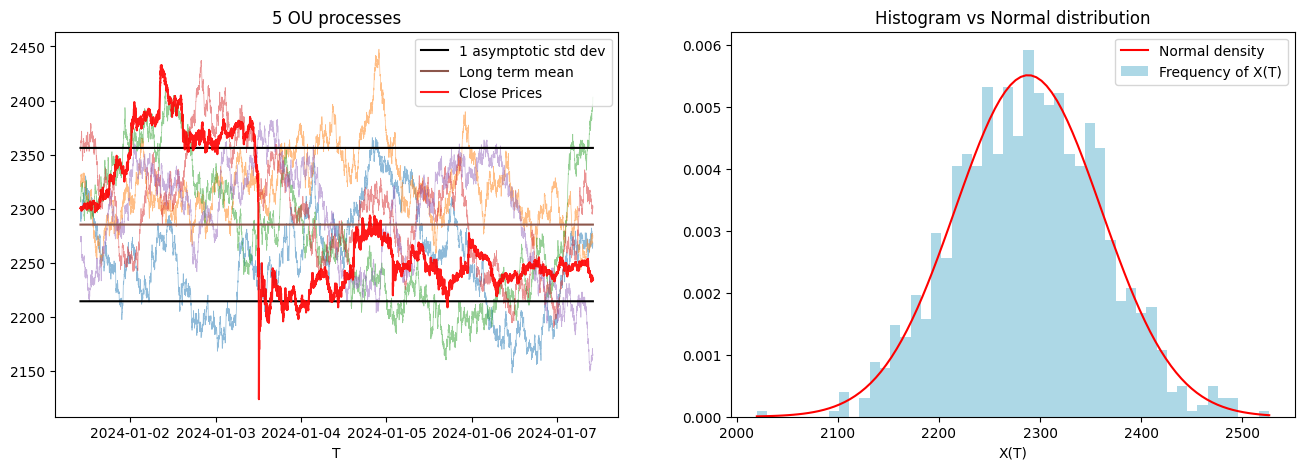

In [ ]:
N_processes = 5  # number of processes
df_X = pd.DataFrame(X[:, :N_processes])
df_X.index = resampled_close_price.index
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, *param)

subset_start = '2024-01-01 10:00:00'
subset_end = '2024-01-07 10:00:00'
subset_resampled_df = resampled_close_price[subset_start:subset_end]
subset_df_X = df_X[subset_start:subset_end]
ones_shape = subset_resampled_df.index.shape

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for col in range(subset_df_X.shape[1]):
    ax1.plot(subset_resampled_df.index, subset_df_X[col], linewidth=0.5, alpha=.5)

ax1.plot(subset_resampled_df.index, (theta + std_asy) * np.ones(shape = ones_shape), label="1 asymptotic std dev", color="black")
ax1.plot(subset_resampled_df.index, (theta - std_asy) * np.ones(shape = ones_shape), color="black")
ax1.plot(subset_resampled_df.index, theta * np.ones(shape = ones_shape), label="Long term mean")
ax1.plot(subset_resampled_df.index, subset_resampled_df, label='Close Prices', color = 'red', alpha=.9)
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")

ax2.plot(x, pdf_fitted, color="r", label="Normal density")
ax2.hist(X_T, density=True, bins=50, facecolor="LightBlue", label="Frequency of X(T)")
ax2.legend()
ax2.set_title("Histogram vs Normal distribution")
ax2.set_xlabel("X(T)")

plt.show()

## Kalman Filter Estimation

In [ ]:
# Convert MLE parameters to Kalman Filter matrices
def ou_to_kalman_matrices(kappa, sigma, dt):
    # Transition matrix - captures mean reversion
    F = [np.exp(-kappa * dt)]

    # Observation matrix - direct observation
    H = [1]

    # Initial state covariance
    P0 = sigma**2 / (2 * kappa)

    # Transition covariance (process noise)
    Q = sigma**2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)

    # Observation covariance (measurement noise)
    R = 0.1  # Tunable parameter

    return F, H, P0, Q, R

In [ ]:
# Get Kalman Filter matrices from OU parameters
F, H, P0, Q, R = ou_to_kalman_matrices(kappa_mle, sigma_mle, dt)

transition_matrix = F,
observation_matrix = H,
initial_state_mean = resampled_close_price.iloc[0],
initial_state_covariance = P0,
observation_covariance = R,
transition_covariance = Q

kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    observation_covariance=observation_covariance,
    transition_covariance=transition_covariance
)

# Fit the Kalman Filter to the trading data, using 3 iterations to get a better estimate
kf = kf.em(resampled_close_price, n_iter=3)
state_means, state_covariances = kf.filter(resampled_close_price)
estimated_close_price = pd.Series(state_means.flatten(), index=resampled_close_price.index)

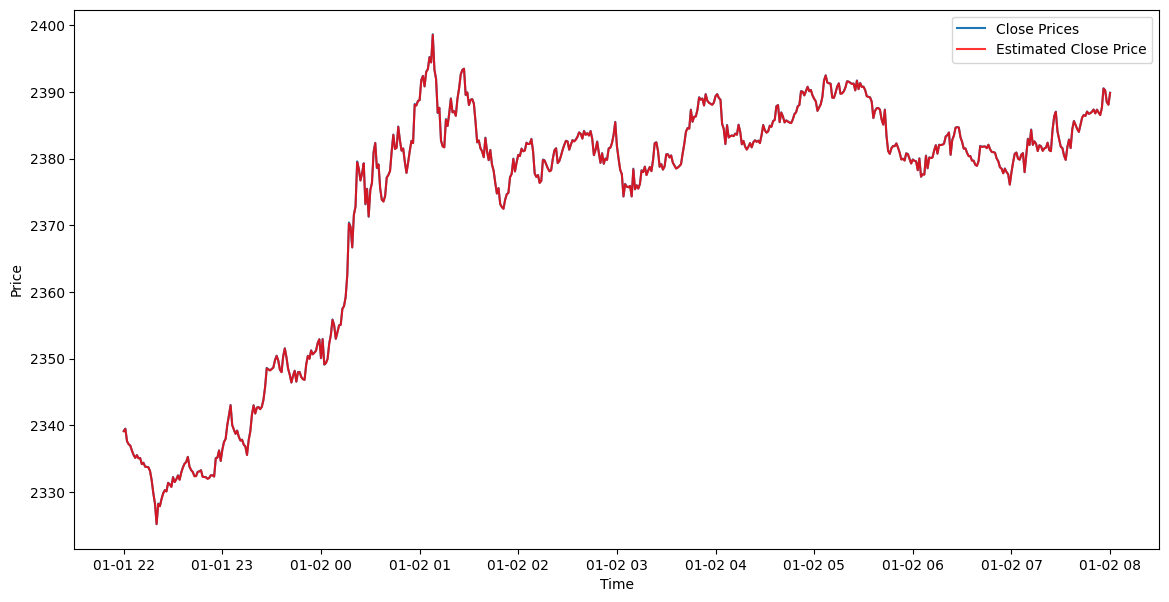

In [ ]:
subset_start = '2024-01-01 22:00:00'
subset_end = '2024-01-02 8:00:00'
subset_resampled_close_price = resampled_close_price[subset_start:subset_end]
subset_estimated_close_price = estimated_close_price[subset_start:subset_end]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(subset_resampled_close_price.index, subset_resampled_close_price, label='Close Prices')
plt.plot(subset_estimated_close_price.index, subset_estimated_close_price, label='Estimated Close Price', color='red', alpha=.8)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

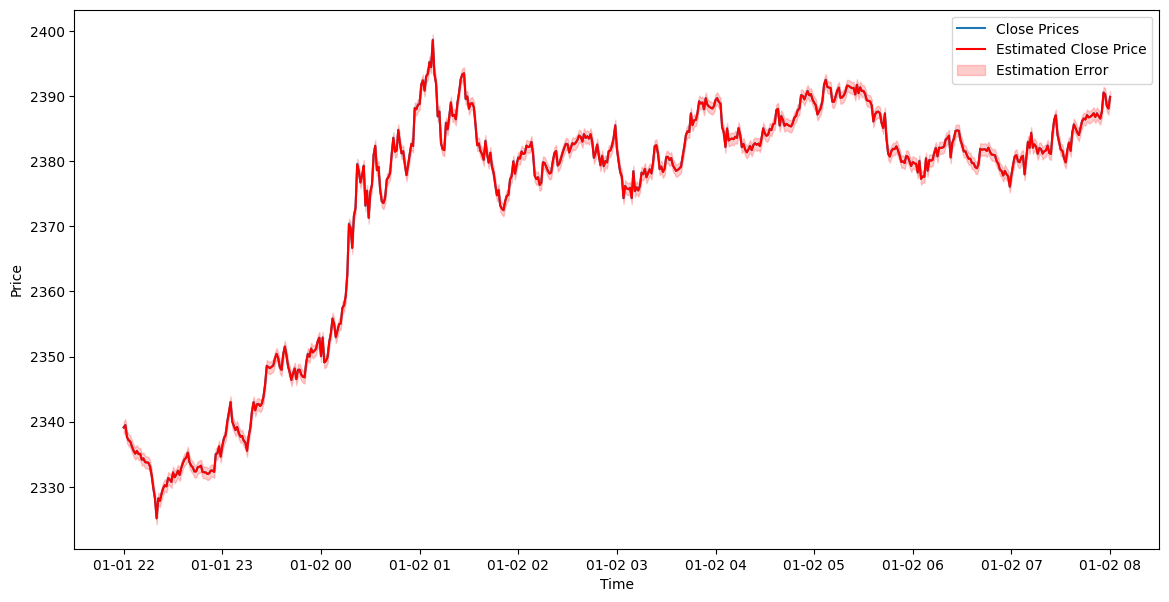

In [ ]:
estimated_error = pd.Series(np.sqrt(state_covariances.flatten()), index=resampled_close_price.index)
subset_estimated_error = estimated_error[subset_start:subset_end]

# Scale the error by a factor of 10 to make it more visible in the plot
subset_estimated_error_scaled = subset_estimated_error * 3
plt.figure(figsize=(14, 7))
plt.plot(subset_resampled_close_price.index, subset_resampled_close_price, label='Close Prices')
plt.plot(subset_estimated_close_price.index, subset_estimated_close_price, label='Estimated Close Price', color='red')
plt.fill_between(subset_estimated_close_price.index,
                 subset_estimated_close_price - subset_estimated_error_scaled,
                 subset_estimated_close_price + subset_estimated_error_scaled,
                 color='red', alpha=0.2, label='Estimation Error')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()